In [10]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path

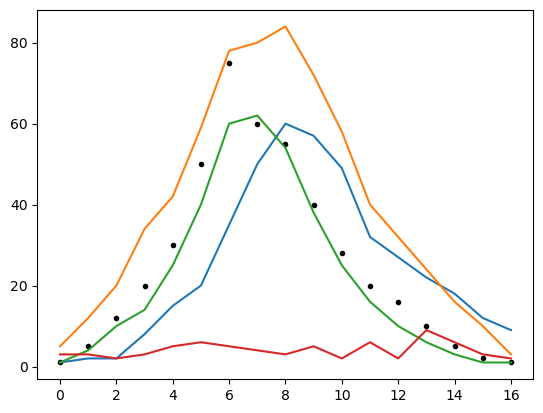

In [5]:
# generate some fake data to practice energy score on

t = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
truey = [1, 5, 12, 20, 30, 50, 75, 60, 55, 40, 28, 20, 16, 10, 5, 2, 1]

traj1 = [1, 2, 2, 8, 15, 20, 35, 50, 60, 57, 49, 32, 27, 22, 18, 12, 9]
traj2 = [5, 12, 20, 34, 42, 59, 78, 80,84, 72, 58, 40, 32, 24,16, 10, 3]
traj3 = [1, 4, 10, 14, 25, 40, 60, 62, 54, 38, 25, 16, 10, 6, 3, 1, 1]
#traj4 = [3, 13, 20, 35, 58, 62, 55, 44, 32, 25, 20, 16, 12, 9, 6, 3, 2]
traj4 = [3,3, 2, 3, 5, 6, 5, 4, 3, 5, 2, 6, 2, 9, 6, 3, 2]

plt.plot(t, truey, 'k.')
plt.plot(t, traj1)
plt.plot(t, traj2)
plt.plot(t, traj3)
plt.plot(t, traj4)

In [6]:
y = truey

trajectories = {0:traj1, 1:traj2, 2:traj3, 3:traj4}

N = 4
M = len(truey)

# first term
ES1 = 0
for i in range(N):
    essqrt = 0
    for k in range(M):
        essqrt += (trajectories[i][k] - y[k])**2

    ES1 += np.sqrt(essqrt)
    
ES1 = 1/N * ES1


# second term
ES2 = 0
for i in range(N):
    for j in range(N):
        essqrt = 0
        for k in range(M):
            essqrt += (trajectories[i][k] - trajectories[j][k])**2
            
        ES2 += np.sqrt(essqrt)
ES2 = 1/(2*N**2) * ES2

ES = ES1 - ES2

In [7]:
ES

31.573030543658966

In [124]:
locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})

In [8]:
# download round 17 data

def pull_scenario_modeling_hub_trajectories(model,dates):
    """pull_scenario_modeling_hub_predictions. Load predictions of the model saved by the scenario modeling
    hub.

    Parameters
    ----------
    model : str
        Model name on thhe
    dates : list or string
        List of potential dates in the iso format, e.g., 'yyyy-mm-dd', for the submission.
    """
    modeltype = [model, model+'-incdeath', model+'-inchosp', model+'-quantile']
    dftotal = pd.DataFrame()
    for m in modeltype:
        predictions = None
        if isinstance(dates,str):
            dates = [dates]
        for date in dates:
            url = f"https://raw.githubusercontent.com/midas-network/covid19-scenario-modeling-hub/master/data-processed/{model}/{date}-{m}"
            for ext in [".gz.parquet", ".parquet"]:
                try:
                    predictions = pd.read_parquet(url+ext)
                except:
                    pass
                
        if predictions is None:
            print(f"Data for model {m} and date {dates} unavailable")
            continue

        
                
        predictions = predictions[predictions['type'] =='sample']
        predictions['quantile'] = predictions['type_id']
        
        
        dftotal = pd.concat([dftotal, predictions])  
        
        
    numweeks = list(dftotal.horizon.unique())

    start_date = list(dftotal.origin_date.unique())[0]
    date_1 = pd.to_datetime(start_date)

    alldates = []
    for wk in numweeks:
        if wk==1:
            d = date_1 + timedelta(days=6*int(wk))
        else:
            d = pd.to_datetime("2023-04-22") + timedelta(weeks=int(wk-1))

        alldates.append(d)

    dfdates = pd.DataFrame({'horizon':numweeks, 'target_end_date':alldates})


    dftotal = dftotal.merge(dfdates, how='inner', on='horizon')
    
    #dftotal = dftotal[dftotal.target_end_date <= pd.to_datetime('2023-08-08')]
    
    return dftotal

In [11]:
#modelsall = ['Ensemble_LOP', 'Ensemble_LOP_untrimmed', 'Ensemble', 'MOBS_NEU-GLEAM_COVID']
modelsall = ['MOBS_NEU-GLEAM_COVID']
dates = ['2023-04-16']

rd=17

for model in modelsall:
    print(model)
    predictions = pull_scenario_modeling_hub_trajectories(model,dates)
    if predictions is not None:
        predictions.to_parquet(f'./dat/{model}_rd{rd}_trajectories.pq', index=False)


MOBS_NEU-GLEAM_COVID
Data for model MOBS_NEU-GLEAM_COVID-incdeath and date ['2023-04-16'] unavailable
Data for model MOBS_NEU-GLEAM_COVID-inchosp and date ['2023-04-16'] unavailable
Data for model MOBS_NEU-GLEAM_COVID-quantile and date ['2023-04-16'] unavailable


In [12]:
model = 'MOBS_NEU-GLEAM_COVID'
rd=17
predictions = pd.read_parquet(f'./dat/{model}_rd{rd}_trajectories.pq')

In [13]:
a = predictions[(predictions.type_id == 1.0) & (predictions.scenario_id == 'A-2023-04-16') & \
                (predictions.location == '12') & (predictions.target == 'inc hosp')]

b = predictions[(predictions.type_id == 2.0) & (predictions.scenario_id == 'A-2023-04-16') & \
                (predictions.location == '12') & (predictions.target == 'inc hosp')]

c = predictions[(predictions.type_id == 3.0) & (predictions.scenario_id == 'A-2023-04-16') & \
                (predictions.location == '12') & (predictions.target == 'inc hosp')]


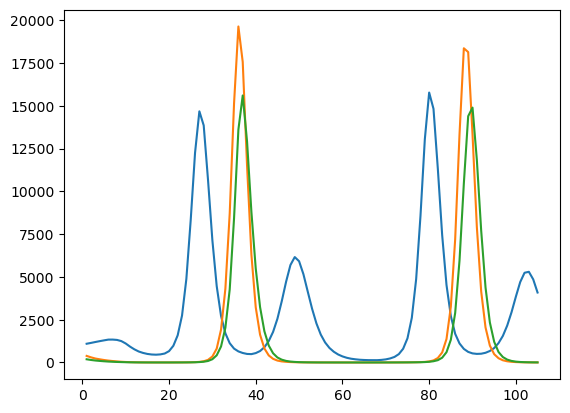

In [14]:
plt.plot(a.horizon, a['value'], '-')
plt.plot(b.horizon, b['value'], '-')
plt.plot(c.horizon, c['value'], '-')

In [17]:
incidence=True
target_obs = 'hospitalization'
observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")

In [76]:
import matplotlib.dates as mdates
def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)

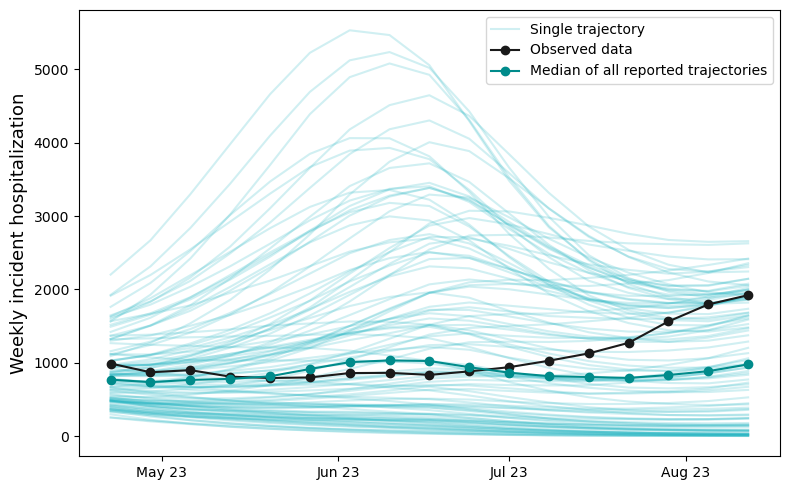

In [84]:
# plot trajectories and observations for scenario A of megaround and for Florida

fig, axes = plt.subplots(figsize=(8, 5))
start_week = Week(2023, 16)

scenario = 'B'
location = '12'
target = 'hosp'
incidence = True

if target == 'hosp':
    target_obs = 'hospitalization'
else:
    target_obs = target_obs
    
observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])

predictionsfilt = predictions[(predictions.scenario_id == scenario + '-2023-04-16') & \
                              (predictions.location == location) & \
                              (predictions.target == 'inc ' + target)  & \
                              (predictions.target_end_date <= observations.date.unique().max()) & \
                              (predictions.target_end_date >= pd.to_datetime(start_week.startdate()))]

for i in predictionsfilt.type_id.unique():
    pfilt = predictionsfilt[predictionsfilt.type_id == i]
    
    if i != predictionsfilt.type_id.unique()[-1]:
        plt.plot(pfilt.target_end_date, pfilt['value'], color = '#17B1BF', alpha = .2)
    else:
        plt.plot(pfilt.target_end_date, pfilt['value'], color = '#17B1BF', alpha = .2, label = 'Single trajectory')
    

    
observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & \
                            (observations['date'] <= pfilt.target_end_date.unique().max())]

#filter location
observations = observations[observations['location'] == location]

#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)

plt.plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', label = 'Observed data')
    

predfiltmed = predictionsfilt.groupby(['horizon']).median().reset_index()

plt.plot(pfilt.target_end_date, predfiltmed['value'],'-o', color = 'darkcyan',
         label = 'Median of all reported trajectories')

plt.ylabel('Weekly incident ' + target_obs, fontsize=13)
    
set_date_axis_fmt(axes)
    
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# calculate energy score

In [119]:
# raw score
start_week = Week(2023, 16)

loclist = list(predictions.location.unique())
loclist.remove('US')

energyscores = {}
for loc in loclist:
    energyscores[loc] = {}
    for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
        
        #scenario = 'B'
        location = loc
        target = 'hosp'
        incidence = True

        if target == 'hosp':
            target_obs = 'hospitalization'
        else:
            target_obs = target_obs

        observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
        observations['date'] = pd.to_datetime(observations['date'])

        predictionsfilt = predictions[(predictions.scenario_id == scenario + '-2023-04-16') & \
                                      (predictions.location == location) & \
                                      (predictions.target == 'inc ' + target)  & \
                                      (predictions.target_end_date <= observations.date.unique().max()) & \
                                      (predictions.target_end_date >= pd.to_datetime(start_week.startdate()))]

        for i in predictionsfilt.type_id.unique():
            pfilt = predictionsfilt[predictionsfilt.type_id == i]


        observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & \
                                    (observations['date'] <= pfilt.target_end_date.unique().max())]

        #filter location
        observations = observations[observations['location'] == location]

        #aggregate to weekly
        observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

        #transform to Observation object
        observations = Observations(observations)


        check = list(observations.date) == list(pfilt.target_end_date)
        if check == False:
            print('dates do not match')


        N = len(predictionsfilt.type_id.unique())
        M = len(observations)

        # first term
        ES1 = 0
        obslist = list(observations.value)
        for i in predictionsfilt.type_id.unique():
            pfilt = predictionsfilt[predictionsfilt.type_id == i]
            essqrt = 0
            for k in range(M):

                essqrt += (list(pfilt.value)[k] - obslist[k])**2

            ES1 += np.sqrt(essqrt)

        ES1 = 1/N * ES1


        # second term
        ES2 = 0
        for i in predictionsfilt.type_id.unique():
            pfilti = predictionsfilt[predictionsfilt.type_id == i]
            for j in predictionsfilt.type_id.unique():
                pfiltj = predictionsfilt[predictionsfilt.type_id == j]
                essqrt = 0
                for k in range(M):
                    essqrt += (list(pfilti.value)[k] - list(pfiltj.value)[k])**2

                ES2 += np.sqrt(essqrt)
        ES2 = 1/(2*N**2) * ES2

        ES = ES1 - ES2

        energyscores[loc][scenario] = ES

In [120]:
energyscores

{'01': {'A': 325.6825542068332,
  'B': 252.66720899429507,
  'C': 284.5663407364943,
  'D': 264.12649184997065,
  'E': 309.7023137149351,
  'F': 265.6221273201496},
 '02': {'A': 47.28984644800264,
  'B': 39.33899080762033,
  'C': 61.660095063813436,
  'D': 38.61176312111252,
  'E': 57.625700868333396,
  'F': 41.42341514426718},
 '04': {'A': 260.9539184849098,
  'B': 449.14644782863013,
  'C': 285.7246614002995,
  'D': 459.99660587562676,
  'E': 271.2002455043352,
  'F': 415.930586630339},
 '05': {'A': 129.24256854619622,
  'B': 133.2568536920818,
  'C': 114.11883963450828,
  'D': 163.12372008795643,
  'E': 119.14142492245082,
  'F': 135.26984748977912},
 '06': {'A': 2662.2675859063506,
  'B': 1685.1117701700573,
  'C': 2560.173978216717,
  'D': 1739.3755344023634,
  'E': 2536.4826721527934,
  'F': 1695.2022229103982},
 '08': {'A': 185.92820951097374,
  'B': 170.03953459601223,
  'C': 165.52505612064465,
  'D': 213.30345900532848,
  'E': 178.37097266366712,
  'F': 165.02788790547214},
 

In [134]:
energyscoresdf = pd.DataFrame()
for loc in energyscores.keys():
    for scenario in energyscores[loc].keys():
        score = energyscores[loc][scenario]
        
        newrow = pd.DataFrame({'Label': 'Scenario '+scenario, 'location':loc, 'energyscore':score, 
                              'target':target}, index=[0])
        
        energyscoresdf = pd.concat([energyscoresdf, newrow])
        
energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])    
            
energyscoresdf = pd.merge(energyscoresdf, locations, how = 'inner', on = 'location')
    


In [139]:
energyscoresdf.to_pickle('energyscore_raw_hosp_rd17.pkl')

# normalized energy score

In [140]:
start_week = Week(2023, 16)

loclist = list(predictions.location.unique())
loclist.remove('US')

norm_energyscoresdf = pd.DataFrame()
#for loc in ['12']:
for loc in loclist:
    for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
        
        #scenario = 'B'
        location = loc
        target = 'hosp'
        incidence = True

        if target == 'hosp':
            target_obs = 'hospitalization'
        else:
            target_obs = target_obs

        observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
        observations['date'] = pd.to_datetime(observations['date'])

        predictionsfilt = predictions[(predictions.scenario_id == scenario + '-2023-04-16') & \
                                      (predictions.location == location) & \
                                      (predictions.target == 'inc ' + target)  & \
                                      (predictions.target_end_date <= observations.date.unique().max()) & \
                                      (predictions.target_end_date >= pd.to_datetime(start_week.startdate()))]

        for i in predictionsfilt.type_id.unique():
            pfilt = predictionsfilt[predictionsfilt.type_id == i]


        observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & \
                                    (observations['date'] <= pfilt.target_end_date.unique().max())]

        #filter location
        observations = observations[observations['location'] == location]

        #aggregate to weekly
        observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

        #transform to Observation object
        observations = Observations(observations)


        check = list(observations.date) == list(pfilt.target_end_date)
        if check == False:
            print('dates do not match')


        N = len(predictionsfilt.type_id.unique())
        M = len(observations)

        # first term
        ES1 = 0
        obslist = list(observations.value)
        for i in predictionsfilt.type_id.unique():
            pfilt = predictionsfilt[predictionsfilt.type_id == i]
            essqrt = 0
            for k in range(M):

                essqrt += ((list(pfilt.value)[k] - obslist[k])/obslist[k])**2

            ES1 += np.sqrt(essqrt)

        ES1 = 1/N * ES1


        # second term
        ES2 = 0
        for i in predictionsfilt.type_id.unique():
            pfilti = predictionsfilt[predictionsfilt.type_id == i]
            for j in predictionsfilt.type_id.unique():
                pfiltj = predictionsfilt[predictionsfilt.type_id == j]
                essqrt = 0
                for k in range(M):
                    essqrt += ((list(pfilti.value)[k] - list(pfiltj.value)[k])/obslist[k])**2

                ES2 += np.sqrt(essqrt)
        ES2 = 1/(2*N**2) * ES2

        ES = ES1 - ES2

        
        newrow = pd.DataFrame({'Label': 'Scenario '+scenario, 'location':loc, 'energyscore':ES, 
                              'target':target}, index=[0])
        
        norm_energyscoresdf = pd.concat([norm_energyscoresdf, newrow])
        
norm_energyscoresdf = norm_energyscoresdf.reset_index()
norm_energyscoresdf = norm_energyscoresdf.drop(columns=['index'])    
            
norm_energyscoresdf = pd.merge(norm_energyscoresdf, locations, how = 'inner', on = 'location')


In [141]:
norm_energyscoresdf

,Label,location,energyscore,target,abbreviation,location_name,population
0,Scenario A,10,1.704856,hosp,DE,Delaware,973764
1,Scenario B,10,3.123405,hosp,DE,Delaware,973764
2,Scenario C,10,1.567900,hosp,DE,Delaware,973764
3,Scenario D,10,3.498954,hosp,DE,Delaware,973764
4,Scenario E,10,1.606803,hosp,DE,Delaware,973764
...,...,...,...,...,...,...,...
259,Scenario B,56,2.375830,hosp,WY,Wyoming,578759
260,Scenario C,56,2.653948,hosp,WY,Wyoming,578759
261,Scenario D,56,2.032620,hosp,WY,Wyoming,578759
262,Scenario E,56,2.838340,hosp,WY,Wyoming,578759


In [142]:
norm_energyscoresdf.to_pickle('energyscore_norm_hosp_rd17.pkl')

# Compare to WIS

In [147]:
wisdf = pd.read_pickle(f'megaround_wis_{target}_rd{rd}_scenarios.pkl') 

wisdf = wisdf.rename(columns={'Location':'location_name'})

wisdf = wisdf[wisdf.Model == 'MOBS_NEU-GLEAM_COVID']

In [148]:
wisdf

,Model,WIS,location_name,Label,Target
21,MOBS_NEU-GLEAM_COVID,56.119092,Alabama,Scenario A,hosp
22,MOBS_NEU-GLEAM_COVID,47.513382,Alabama,Scenario B,hosp
23,MOBS_NEU-GLEAM_COVID,57.532292,Alabama,Scenario C,hosp
24,MOBS_NEU-GLEAM_COVID,47.612094,Alabama,Scenario D,hosp
25,MOBS_NEU-GLEAM_COVID,57.057019,Alabama,Scenario E,hosp
...,...,...,...,...,...
2816,MOBS_NEU-GLEAM_COVID,8.725747,Wyoming,Scenario C,hosp
2817,MOBS_NEU-GLEAM_COVID,6.247210,Wyoming,Scenario D,hosp
2818,MOBS_NEU-GLEAM_COVID,8.558154,Wyoming,Scenario E,hosp
2819,MOBS_NEU-GLEAM_COVID,6.293895,Wyoming,Scenario F,hosp


In [155]:
allscores = pd.merge(energyscoresdf, wisdf, how='inner', on=['location_name', 'Label'])

In [156]:
allscores

,Label,location,energyscore,target,abbreviation,location_name,population,Model,WIS,Target
0,Scenario A,10,34.972849,hosp,DE,Delaware,973764,MOBS_NEU-GLEAM_COVID,6.120538,hosp
1,Scenario B,10,48.469963,hosp,DE,Delaware,973764,MOBS_NEU-GLEAM_COVID,11.104731,hosp
2,Scenario C,10,32.926073,hosp,DE,Delaware,973764,MOBS_NEU-GLEAM_COVID,6.147248,hosp
3,Scenario D,10,53.042694,hosp,DE,Delaware,973764,MOBS_NEU-GLEAM_COVID,11.097555,hosp
4,Scenario E,10,34.672491,hosp,DE,Delaware,973764,MOBS_NEU-GLEAM_COVID,6.141511,hosp
...,...,...,...,...,...,...,...,...,...,...
259,Scenario B,56,36.046289,hosp,WY,Wyoming,578759,MOBS_NEU-GLEAM_COVID,6.374551,hosp
260,Scenario C,56,40.088233,hosp,WY,Wyoming,578759,MOBS_NEU-GLEAM_COVID,8.725747,hosp
261,Scenario D,56,30.833566,hosp,WY,Wyoming,578759,MOBS_NEU-GLEAM_COVID,6.247210,hosp
262,Scenario E,56,42.852647,hosp,WY,Wyoming,578759,MOBS_NEU-GLEAM_COVID,8.558154,hosp


Text(0, 0.5, 'Energy score')

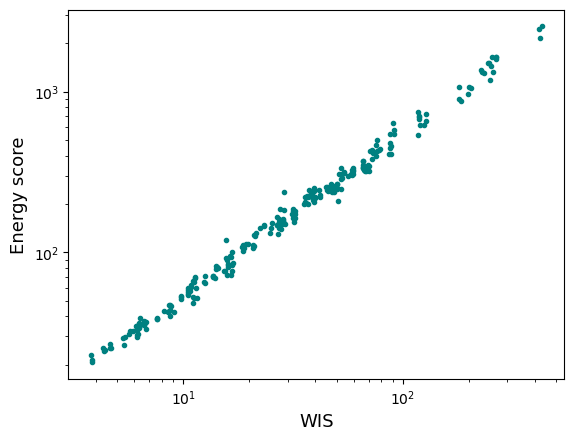

In [165]:
plt.loglog(allscores.WIS, allscores.energyscore,'.', color = 'teal')

plt.xlabel('WIS', fontsize=13)
plt.ylabel('Energy score', fontsize=13)
# un normalized for both

# cannot compare one normalized, another unnormalized
# either both WIS and energy score must be normalized to account for magnitude differences or both are just raw scores

# WIS and energy score are highly correlated